# Data Exploration & Feature Engineering
1. [Zeitbezogene Features hinzufügen](#1)
1. [Missing values](#2)
1. [Feature Importance](#3)
1. [Saisonalität und Trends](#4)
1. [Korrelation der Features](#5)

In [36]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import mutual_info_regression

plt.style.use('ggplot')

print("Setup complete")

Setup complete


In [37]:
df = pd.read_csv('../input/2024-01-11/austin10_dataset.csv')
df.timestamp = pd.to_datetime(df.timestamp)

df.describe()

,dataid,timestamp,air1,air2,airwindowunit1,bathroom1,bathroom2,bedroom1,bedroom2,bedroom3,...,utilityroom1,venthood1,use,construction_year,n_residents,n_rooms,total_area,outdoor_temp,app_outdoor_temp,humidity
count,86240.000000,86240,77474.00000,8386.000000,8684.000000,25541.000000,8362.000000,34615.000000,17062.000000,8386.000000,...,16711.000000,17071.000000,86240.000000,86240.000000,86240.000000,86240.000000,78101.000000,86220.000000,86220.000000,86220.000000
mean,5306.904661,2018-07-03 08:02:19.675324416,0.47482,0.060127,0.038220,0.010429,0.001780,0.052048,0.084458,0.063439,...,0.152101,0.014890,1.467660,1997.897982,2.518808,8.239726,193.815834,20.139782,20.646371,0.701433
min,661.000000,2018-01-01 06:00:00,-0.01275,-0.018250,0.000000,-0.001000,-0.001000,-0.001000,0.000000,0.004000,...,-0.213750,-0.002250,0.003000,1950.000000,0.000000,4.000000,154.590000,-8.660000,-13.580000,0.130000
25%,3456.000000,2018-04-02 20:45:00,0.00025,-0.005250,0.002250,0.002000,0.000000,0.007250,0.006500,0.014000,...,0.000000,0.000000,0.554500,2006.000000,2.000000,6.000000,159.790000,13.430000,13.430000,0.540000
50%,4767.000000,2018-07-02 10:00:00,0.00400,-0.004500,0.023000,0.004500,0.000000,0.019000,0.061500,0.056250,...,0.002000,0.005750,1.011750,2007.000000,2.000000,9.000000,185.810000,21.680000,22.080000,0.740000
75%,7800.000000,2018-10-02 22:00:00,0.72875,-0.003250,0.024000,0.023750,0.001500,0.071250,0.148000,0.076500,...,0.172625,0.018000,1.961750,2008.000000,3.000000,10.000000,213.680000,26.640000,28.190000,0.880000
max,9922.000000,2019-01-01 05:00:00,4.14650,1.310250,1.303750,0.843250,0.065500,0.604750,0.520250,0.444250,...,1.077500,0.143000,14.804500,2009.000000,5.000000,11.000000,260.130000,41.990000,42.340000,1.000000
std,2887.019401,NaN,0.76862,0.189653,0.082397,0.013313,0.004697,0.069521,0.079655,0.067243,...,0.262641,0.019348,1.290707,19.795430,1.275424,2.246753,35.744520,9.183760,10.345560,0.211698


<a id="1"></a>
## 1. Zeitbezogene Features hinzufügen

In [38]:
df['hour'] = df.timestamp.dt.hour
df['wday'] = df.timestamp.dt.dayofweek  # 0 = Montag, 6 = Sonntag
df['day'] = df.timestamp.dt.day
df['month'] = df.timestamp.dt.month

In [39]:
df.set_index(['dataid', 'timestamp'], inplace=True)

<a id="2"></a>
## 2. Missing values
https://www.kaggle.com/code/alexisbcook/missing-values

In [40]:
# Prozentsatz der fehlenden Werte für jede Spalte
missing_share = df.isnull().mean() * 100

# Maximale Länge der Spaltennamen
max_column_name_len = max(len(column) for column in df.columns)

for column_name, percent_val in missing_share.items():
    if percent_val > 0:
        print(f"{column_name.ljust(max_column_name_len)}\t{percent_val:.2f}%")

air1                	10.16%
air2                	90.28%
airwindowunit1      	89.93%
bathroom1           	70.38%
bathroom2           	90.30%
bedroom1            	59.86%
bedroom2            	80.22%
bedroom3            	90.28%
car1                	59.66%
clotheswasher1      	10.73%
diningroom1         	89.87%
dishwasher1         	0.57%
disposal1           	50.02%
drye1               	20.24%
dryg1               	70.14%
furnace1            	0.58%
furnace2            	90.27%
garage1             	89.85%
kitchen1            	80.15%
kitchen2            	90.28%
kitchenapp1         	30.59%
kitchenapp2         	50.89%
lights_plugs1       	30.22%
lights_plugs2       	39.66%
lights_plugs3       	59.94%
lights_plugs4       	89.94%
livingroom1         	60.41%
microwave1          	20.45%
office1             	69.63%
outsidelights_plugs1	90.30%
oven1               	40.44%
oven2               	99.99%
range1              	79.74%
refrigerator1       	20.46%
refrigerator2       	80.50%
utilityroom1        	8

### Was auffällt: Da es z.T. mehrere Badezimmer, Schlafzimmer, usw. gibt, entsteht die Problematik, dass die Spalten für die Werte z.B. eines 2. oder 3. Schlafzimmers bei den meisten Häusern leer sind, da nicht vorhanden. Um dies zu umgehen, werden die Spalten im Folgenden jeweils zusammengefasst.
### Außerdem: Um Data Leakage zu verhindern, können beim Testing später keine einzelnen Messwerte übergeben werden. Um dennoch einen Teil der Informationen hiervon zu verwenden, wird die Anzahl der im Haus vorhandenen Geräte jeweils gespeichert

In [41]:
# Identifizieren der Spaltenpaare
spaltenpaare = {}
for spalte in df.columns:
    if spalte[-1].isdigit():
        basisname = spalte[:-1]
        if basisname in spaltenpaare:
            spaltenpaare[basisname].append(spalte)
        else:
            spaltenpaare[basisname] = [spalte]

# Zusammenfassen der Spalten und Erstellen neuer Spalten
for basisname, spalten in spaltenpaare.items():
    df[basisname] = df[spalten].sum(axis=1, min_count=1)  # Summieren mit Berücksichtigung fehlender Werte
    df[f"n_{basisname}"] = df[spalten].notnull().sum(axis=1)  # Zählen der nicht-leeren Spalten

# Entfernen der ursprünglichen Spalten
for spalten in spaltenpaare.values():
    df.drop(columns=spalten, inplace=True)

In [42]:
# Prozentsatz der fehlenden Werte für jede Spalte
missing_share = df.isnull().mean() * 100

# Maximale Länge der Spaltennamen
max_column_name_len = max(len(column) for column in df.columns)

for column_name, percent_val in missing_share.items():
    if percent_val > 0:
        print(f"{column_name.ljust(max_column_name_len)}\t{percent_val:.2f}%")

total_area           	9.44%
outdoor_temp         	0.02%
app_outdoor_temp     	0.02%
humidity             	0.02%
air                  	10.16%
airwindowunit        	89.93%
bathroom             	60.69%
bedroom              	49.80%
car                  	59.66%
clotheswasher        	10.73%
diningroom           	89.87%
dishwasher           	0.57%
disposal             	50.02%
drye                 	20.24%
dryg                 	70.14%
furnace              	0.58%
garage               	89.85%
kitchen              	80.15%
kitchenapp           	30.59%
lights_plugs         	30.22%
livingroom           	60.41%
microwave            	20.45%
office               	69.63%
outsidelights_plugs  	90.30%
oven                 	40.44%
range                	79.74%
refrigerator         	20.46%
utilityroom          	80.62%
venthood             	80.21%


<a id="3"></a>
## 3. Feature Importance
### Mutual Information
https://www.kaggle.com/code/ryanholbrook/mutual-information

Vorläufige Auffüllung durch Imputation, aber nicht auf den gespeicherten Datensatz, um Data Leakage zu verhindern

In [43]:
imputed_df = df.copy()

# Spalten für jede Imputationsstrategie bestimmen
few_missing = missing_share[(missing_share > 0) & (missing_share <= 5)].index.tolist()
moderate_missing = missing_share[(missing_share > 5) & (missing_share <= 50)].index.tolist()
many_missing = missing_share[missing_share > 50].index.tolist()

# Imputation
# Wenig fehlende Daten: Ersetzen durch den Median
simple_imputer = SimpleImputer(strategy='median')
imputed_df[few_missing] = simple_imputer.fit_transform(imputed_df[few_missing])

# Moderate fehlende Daten: KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)
imputed_df[moderate_missing] = knn_imputer.fit_transform(imputed_df[moderate_missing])

# Sehr viele fehlende Daten: Entfernung der Spalte
imputed_df.drop(many_missing, axis=1, inplace=True)

In [44]:
def create_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.figure(figsize=(10, 10))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

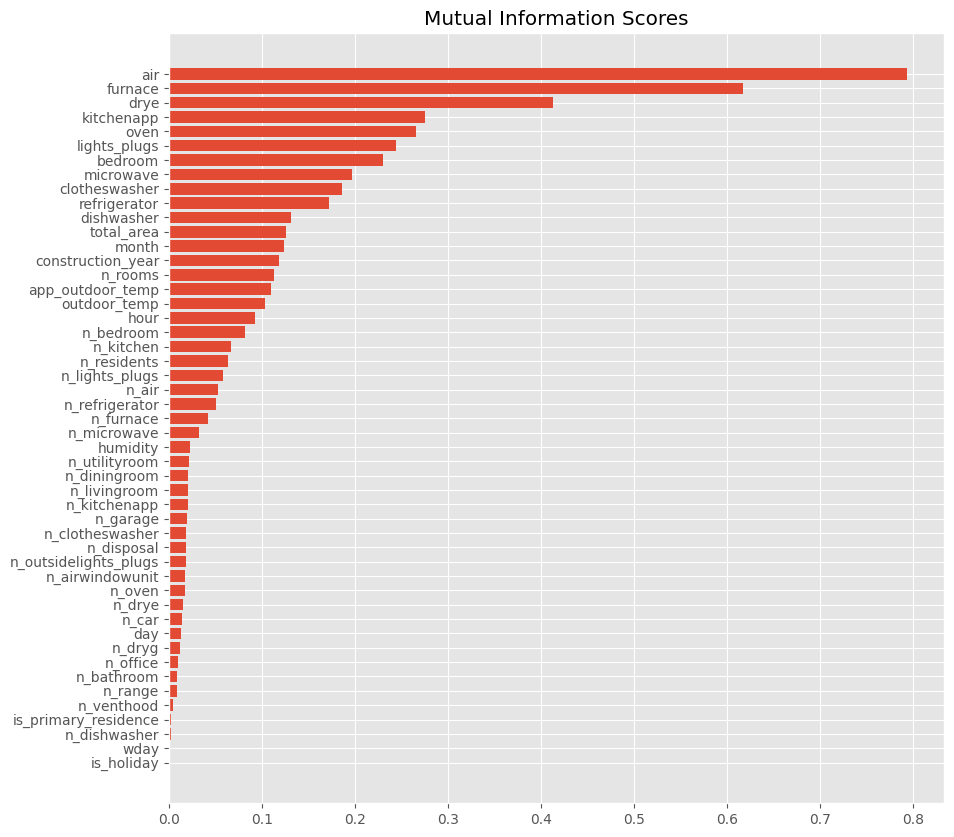

In [60]:
y = imputed_df.use
X = imputed_df.drop('use', axis=1)

discrete_features = X.dtypes == int

mi_scores = create_mi_scores(X, y, discrete_features)
plot_mi_scores(mi_scores)

### 1. Warum hat is_holiday einen niedrigen MI Score?

In [46]:
# Berechnen des Durchschnitts für 'use' basierend auf dem Wert von 'is_holiday'
average_use = imputed_df.groupby('is_holiday').use.mean()

# Prozentualer Unterschied zwischen den Durchschnittswerten
percent_difference = ((average_use[True] - average_use[False]) / average_use[False]) * 100

print(f"An Feiertagen werden {percent_difference:.2f} % mehr Strom verbraucht als an anderen Tagen.")

An Feiertagen werden -1.93 % mehr Strom verbraucht als an anderen Tagen.


<Axes: xlabel='is_holiday', ylabel='use'>

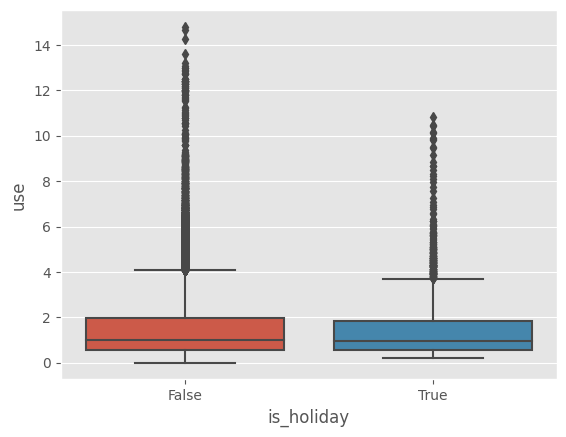

In [47]:
sns.boxplot(x="is_holiday", y="use", data=imputed_df)

### Erkenntnis: Feiertage haben keinen besonderen Einfluss auf den durchschnittlichen Stromverbrauch. Überraschenderweise wird an Feiertagen sogar minimal weniger Strom verbraucht als an anderen Tagen
### 2. Warum haben "n_dishwasher" und "is_primar_residence" einen niedrigen MI Score?

In [48]:
print("Werte für n_dishwasher: ", imputed_df.n_dishwasher.unique())
print("Werte für is_primary_residence: ", imputed_df.is_primary_residence.unique())

Werte für n_dishwasher:  [1 0]
Werte für is_primary_residence:  [ True]


In [49]:
n_dishwasher_check = (imputed_df.n_dishwasher == 1).mean() * 100
is_primary_residence_check = imputed_df.is_primary_residence.mean() * 100

print(f"{n_dishwasher_check:.2f} % der Häuser haben genau einen Geschirrspüler.")
print(f"{is_primary_residence_check:.2f} % der Häuser sind als Hauptwohnsitz angegeben.")

99.43 % der Häuser haben genau einen Geschirrspüler.
100.00 % der Häuser sind als Hauptwohnsitz angegeben.


### Erkenntnis: Features sind nicht aussagekräftig, da (fast) alle Einträge gleich sind --> Eliminierung dieser Features
### 3. Warum hat "wday" einen niedrigen MI Score?
Auch wenn sich der durchschnittliche Verbrauch pro Wochentag verändert (vgl. nachfolgende Grafik "Normalisierter durchschnittlicher Verbrauch pro Wochentag"), sind die Schwankungen verglichen mit den Schwankungen pro Stunde des Tages oder pro Monat kaum messbar und deshalb nicht aussagekräftig. 

In [50]:
less_important_features = ["is_holiday", "n_dishwasher", "is_primary_residence", "wday"]
df.drop(less_important_features, axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 86240 entries, (661, Timestamp('2018-01-01 07:00:00')) to (9922, Timestamp('2019-01-01 05:00:00'))
Data columns (total 60 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   use                    86240 non-null  float64
 1   construction_year      86240 non-null  int64  
 2   n_residents            86240 non-null  int64  
 3   n_rooms                86240 non-null  int64  
 4   total_area             78101 non-null  float64
 5   outdoor_temp           86220 non-null  float64
 6   app_outdoor_temp       86220 non-null  float64
 7   humidity               86220 non-null  float64
 8   hour                   86240 non-null  int32  
 9   day                    86240 non-null  int32  
 10  month                  86240 non-null  int32  
 11  air                    77474 non-null  float64
 12  n_air                  86240 non-null  int64  
 13  airwindowunit          8684 non-n

In [51]:
# Als csv-Datei speichern
df.to_csv('austin10_hourly.csv')

<a id="4"></a>
## 4. Saisonalität und Trends

In [52]:
df_plot = imputed_df.copy()
df_plot.reset_index(level='timestamp', inplace=True)

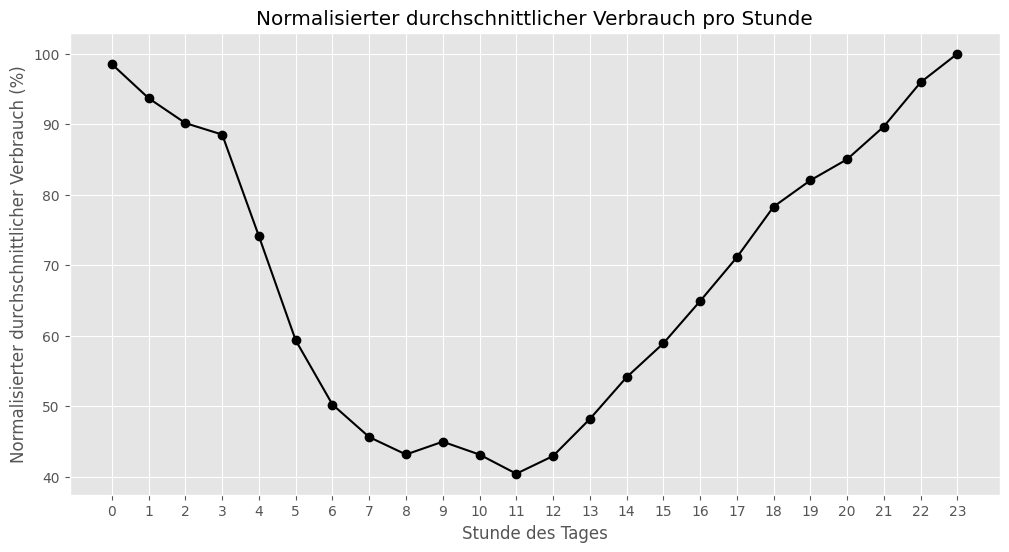

In [53]:
# Gruppieren nach Stunde und Berechnen des Durchschnitts
hourly_avg = df_plot.groupby('hour').use.mean()

# Normalisieren der Werte auf 100%
max_value = hourly_avg.max()
hourly_avg_normalized = (hourly_avg / max_value) * 100

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(hourly_avg_normalized.index, hourly_avg_normalized.values, color='black', marker='o')
plt.title('Normalisierter durchschnittlicher Verbrauch pro Stunde')
plt.xlabel('Stunde des Tages')
plt.ylabel('Normalisierter durchschnittlicher Verbrauch (%)')
plt.xticks(range(24))
plt.show()

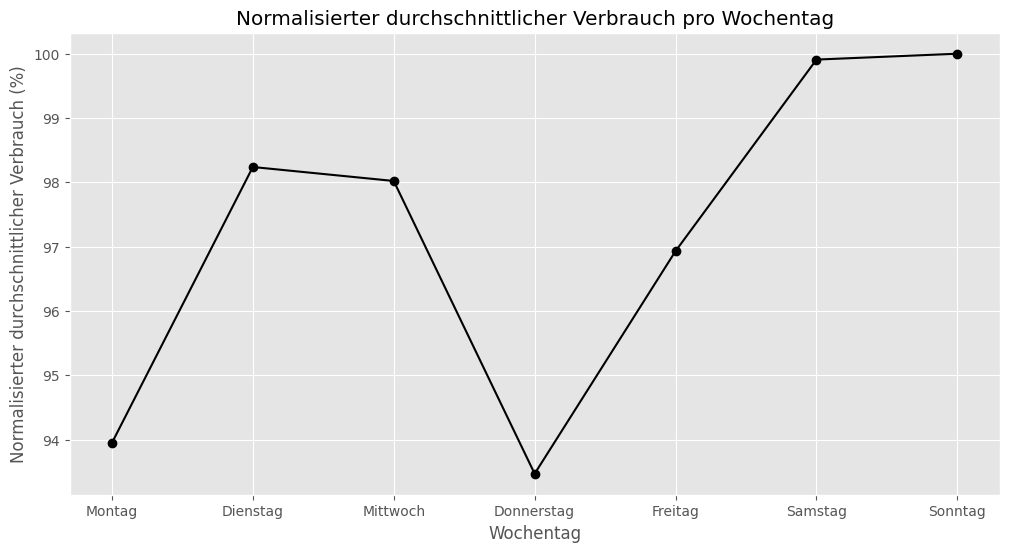

In [54]:
# Gruppieren nach Wochentag und Berechnen des Durchschnitts
weekly_avg = df_plot.groupby('wday').use.mean()

# Normalisieren der Werte auf 100%
max_value = weekly_avg.max()
weekly_avg_normalized = (weekly_avg / max_value) * 100

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(weekly_avg_normalized.index, weekly_avg_normalized.values, color='black', marker='o')
plt.title('Normalisierter durchschnittlicher Verbrauch pro Wochentag')
plt.xlabel('Wochentag')
plt.ylabel('Normalisierter durchschnittlicher Verbrauch (%)')
plt.xticks(range(7), ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag'])
plt.show()

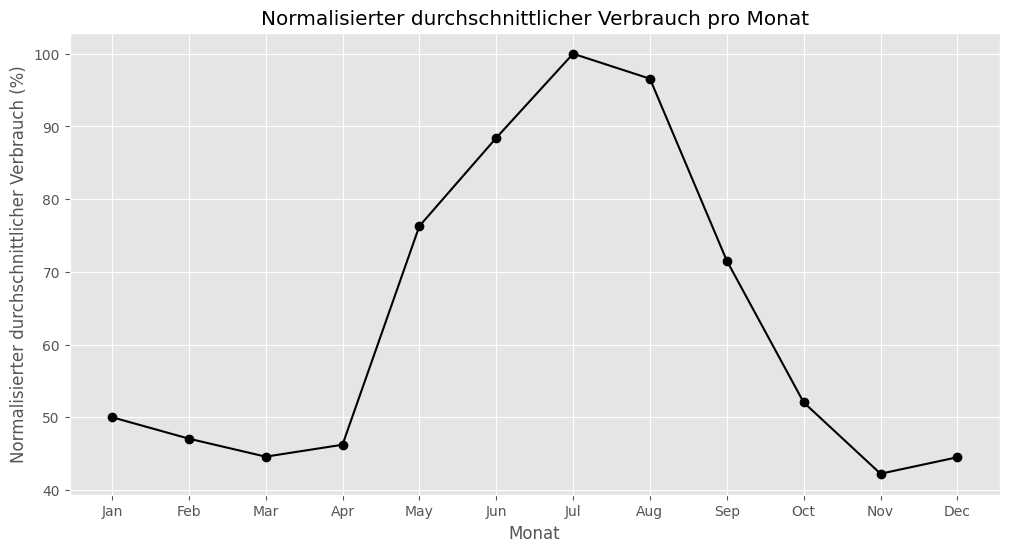

In [55]:
# Monatsabkürzungen erstellen
df_plot['month_abbr'] = df_plot.timestamp.dt.strftime('%b')

# Gruppieren nach Monat und Berechnen des Durchschnitts
monthly_avg = df_plot.groupby('month').use.mean()
monthly_avg.index = df_plot.month_abbr.unique()

# Normalisieren der Werte auf 100%
max_value = monthly_avg.max()
monthly_avg_normalized = (monthly_avg / max_value) * 100

# Plot erstellen
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_normalized.index, monthly_avg_normalized.values, color='black', marker='o')
plt.title('Normalisierter durchschnittlicher Verbrauch pro Monat')
plt.xlabel('Monat')
plt.ylabel('Normalisierter durchschnittlicher Verbrauch (%)')
plt.show()

### Warum steigt der Stromverbrauch in der Nacht an?
1. Tarifabhängigkeit: In vielen Ländern gibt es verschiedene Stromtarife, bei denen der Preis pro Kilowattstunde je nach Tageszeit variiert. In der Nacht kann der Strompreis niedriger sein, insbesondere in Zeiten geringer Nachfrage. Dies kann dazu führen, dass Menschen ihre energieintensiven Aktivitäten, wie das Waschen von Wäsche oder das Heizen von Räumen, in die Nachtstunden verlagern, um Geld zu sparen.
1. Netzauslastung: Tagsüber gibt es in der Regel eine höhere Nachfrage nach Strom, da viele Menschen zu dieser Zeit ihre Geräte nutzen und Unternehmen aktiv sind. In der Nacht kann die Nachfrage geringer sein, was das Stromnetz weniger belastet. Dies ermöglicht es, dass einige Geräte, die normalerweise viel Strom benötigen, in der Nacht effizienter arbeiten können.
1. Programmierbare Geräte: Moderne Haushaltsgeräte wie Waschmaschinen und Geschirrspüler sind oft programmierbar und können so eingestellt werden, dass sie während der günstigeren Tarifzeiten arbeiten. Dies ermöglicht es den Nutzern, den Stromverbrauch zu optimieren und Energiekosten zu senken.
1. Thermische Bedingungen: In einigen Fällen kann es sinnvoller sein, Geräte wie Heizungen oder Klimaanlagen nachts zu betreiben, um die thermische Effizienz zu maximieren. In der Nacht kann es kühler sein, was bedeutet, dass Heizungen weniger arbeiten müssen oder Klimaanlagen effizienter kühlen können.
1. Stichwort: **Time-of-Use-Tarife (TOU-Tarife)**

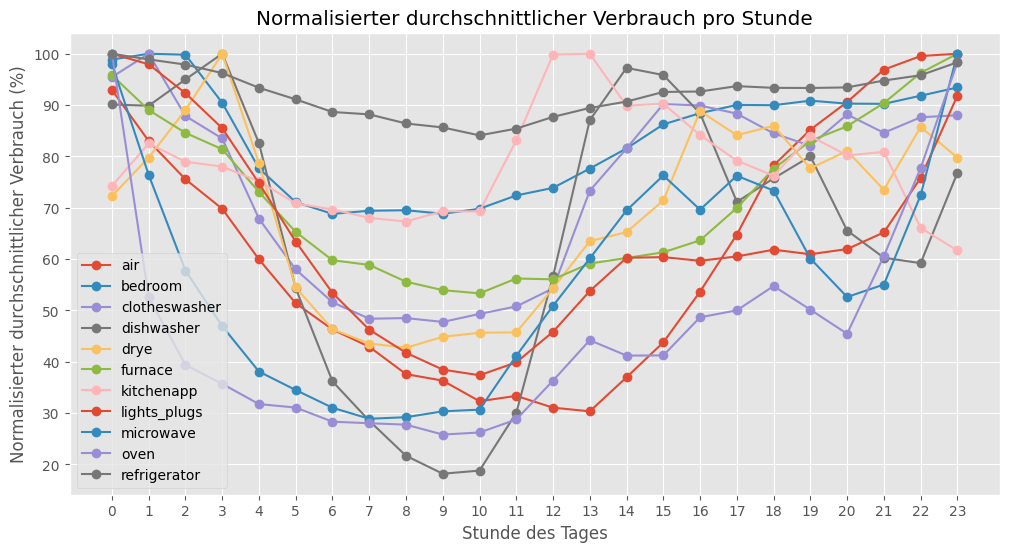

In [56]:
columns_to_plot = ['air', 'bedroom', 'clotheswasher', 'dishwasher', 'drye', 'furnace',
                   'kitchenapp', 'lights_plugs', 'microwave', 'oven', 'refrigerator']

plt.figure(figsize=(12, 6))

for column in columns_to_plot:
    hourly_avg = df_plot.groupby('hour')[column].mean()
    max_value = hourly_avg.max()
    hourly_avg_normalized = (hourly_avg / max_value) * 100
    plt.plot(hourly_avg_normalized.index, hourly_avg_normalized.values, marker='o', label=column)

plt.title('Normalisierter durchschnittlicher Verbrauch pro Stunde')
plt.xlabel('Stunde des Tages')
plt.ylabel('Normalisierter durchschnittlicher Verbrauch (%)')
plt.xticks(range(24))
plt.legend()
plt.show()

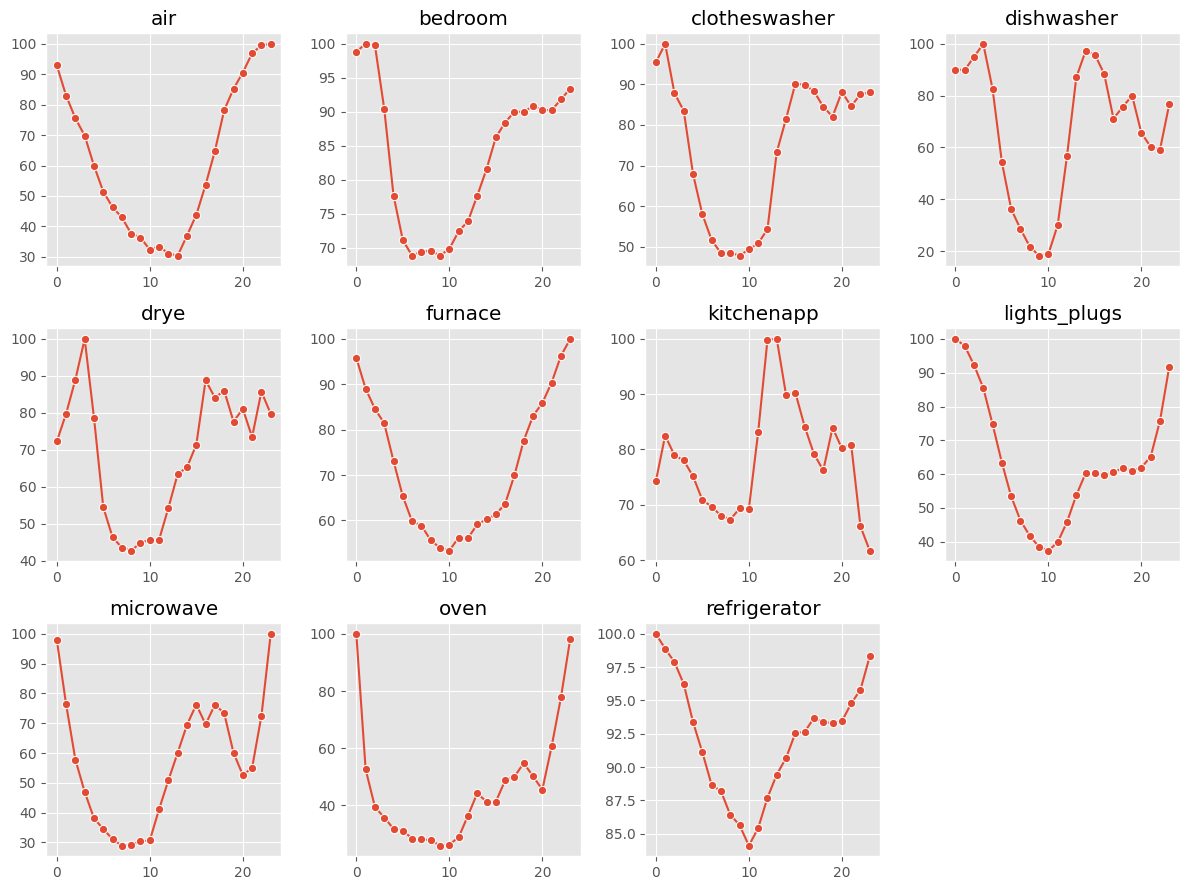

In [57]:
num_cols = 4
num_rows = 3

plt.figure(figsize=(3 * num_cols, 3 * num_rows))

for i, column in enumerate(columns_to_plot):
    plt.subplot(num_rows, num_cols, i + 1)  # Nummer der Zeilen, Nummer der Spalten, aktueller Subplot

    hourly_avg = df_plot.groupby('hour')[column].mean()
    max_value = hourly_avg.max()
    hourly_avg_normalized = (hourly_avg / max_value) * 100
    sns.lineplot(x=hourly_avg_normalized.index, y=hourly_avg_normalized.values, marker='o')

    plt.title(column)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

<a id="5"></a>
## 5. Korrelation der Features

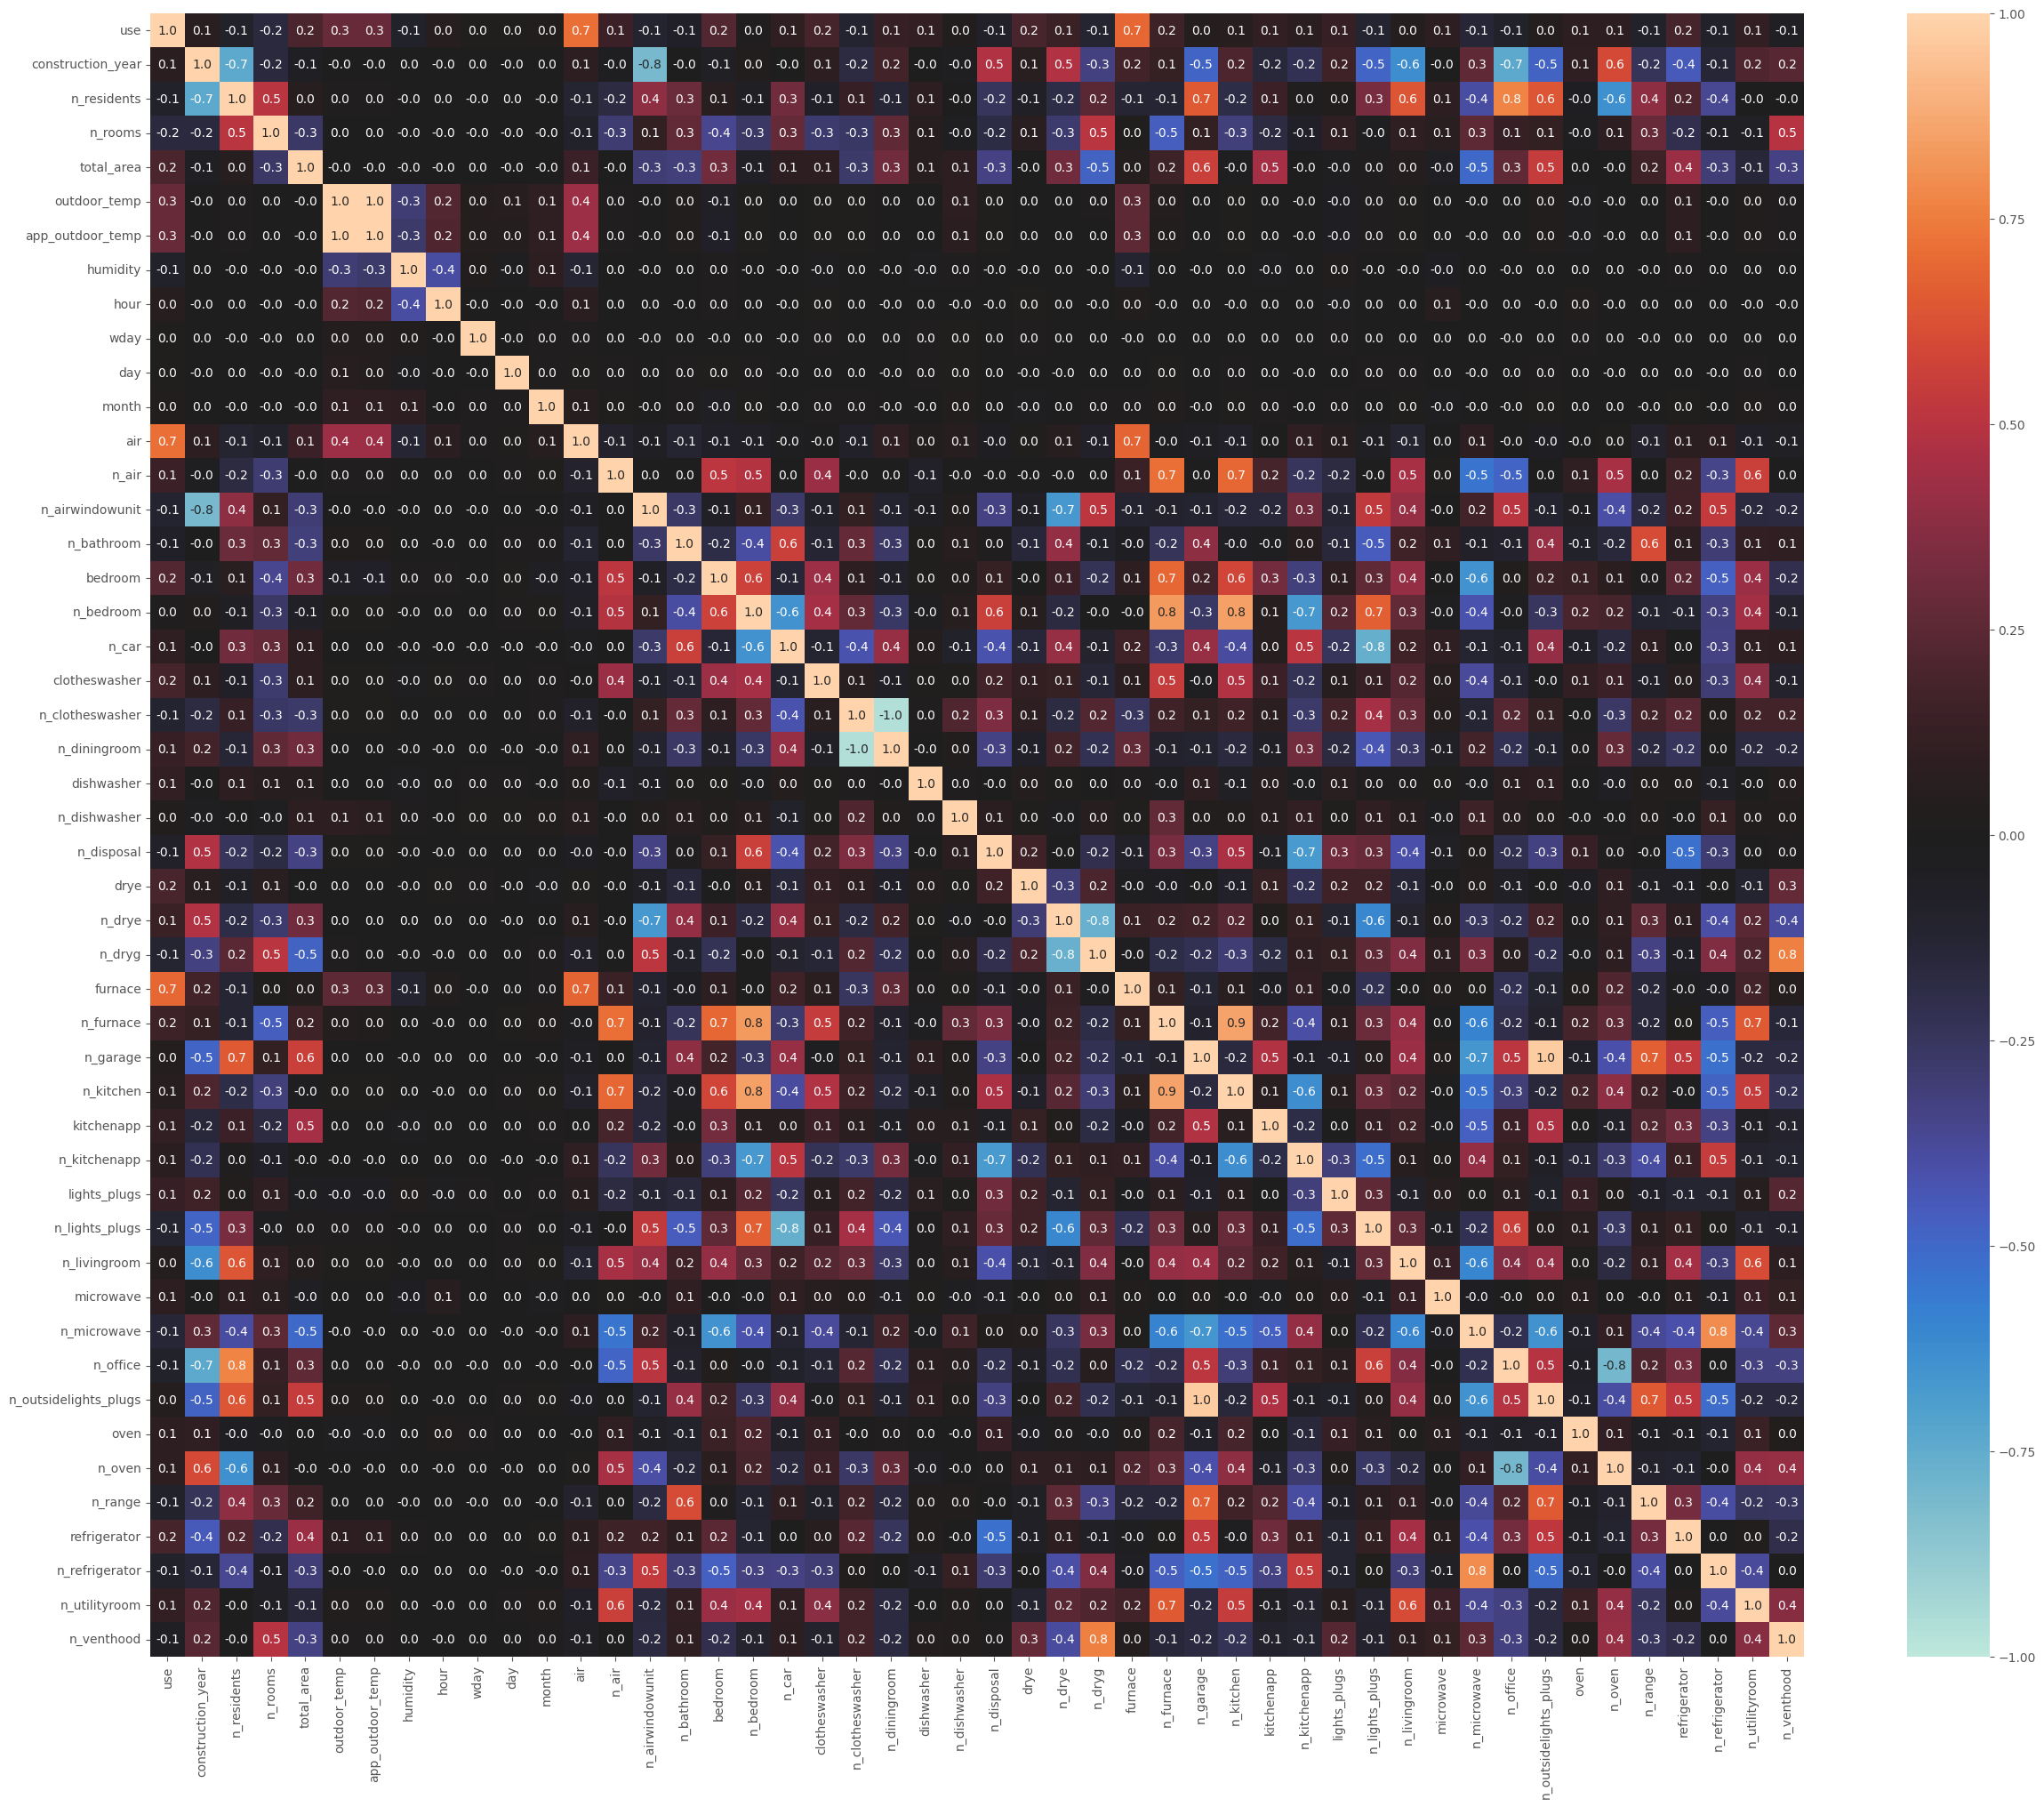

In [58]:
fig = plt.subplots(figsize=(30, 24))
corr = imputed_df.select_dtypes(include=['number']).corr()
sns.heatmap(corr, annot=True, fmt=".1f", vmin=-1.0, vmax=1.0, center=0)
plt.show()

In [59]:
# Schleife durch die Korrelationsmatrix und extrahiere Paare mit (positiver oder negativer) Korrelation >= 0,8
threshold = 0.8
correlation_pairs = []

for i in range(len(corr.columns)):
    for j in range(i + 1, len(corr.columns)):
        if abs(corr.iloc[i, j]) >= threshold:
            feature1 = corr.columns[i]
            feature2 = corr.columns[j]
            correlation_value = corr.iloc[i, j]
            correlation_pairs.append(f"{feature1} - {feature2}: {correlation_value:.1f}")

# Ausgabe der gefundenen Paare
for pair in correlation_pairs:
    print(pair)

construction_year - n_airwindowunit: -0.8
outdoor_temp - app_outdoor_temp: 1.0
n_bedroom - n_furnace: 0.8
n_bedroom - n_kitchen: 0.8
n_clotheswasher - n_diningroom: -1.0
n_furnace - n_kitchen: 0.9
n_garage - n_outsidelights_plugs: 1.0
n_office - n_oven: -0.8


Hier sind Erklärungen für die jeweiligen Korrelationen basierend auf realen Weltbeispielen und plausiblen Annahmen:

1. `construction_year - n_airwindowunit: -0.8`
   - Begründung: Diese Korrelation von -0,8 könnte darauf hinweisen, dass ältere Gebäude tendenziell weniger moderne Klimaanlagen oder Fensterluftgeräte haben. Neuere Gebäude könnten hingegen häufiger mit effizienteren Klimaanlagen ausgestattet sein.

2. `outdoor_temp - app_outdoor_temp: 1.0`
   - Begründung: Diese perfekte positive Korrelation von 1,0 deutet darauf hin, dass `app_outdoor_temp` und `outdoor_temp` identische oder sehr eng miteinander verknüpfte Daten sind. Möglicherweise handelt es sich bei `app_outdoor_temp` um eine vom Hersteller bereitgestellte oder berechnete Schätzung der tatsächlichen Außentemperatur `outdoor_temp`.

3. `n_bedroom - n_furnace: 0,8`
   - Begründung: Eine hohe positive Korrelation von 0,8 zwischen der Anzahl der Schlafzimmer und der Anzahl der Heizungen (`furnace`) könnte darauf hinweisen, dass größere Wohnungen mit mehr Schlafzimmern tendenziell mehr Heizungen haben, um die zusätzlichen Räume zu beheizen.

4. `n_bedroom - n_kitchen: 0,8`
   - Begründung: Ähnlich wie bei der vorherigen Korrelation könnte eine hohe positive Korrelation von 0,8 darauf hindeuten, dass größere Wohnungen tendenziell auch größere Küchen haben, was zu einer höheren Anzahl von Schlafzimmern und Küchen führt.

5. `n_car - n_lights_plugs: -0,9`
   - Begründung: Eine starke negative Korrelation von -0,9 könnte darauf hinweisen, dass Haushalte mit mehr Autos tendenziell weniger Lichter und Steckdosen nutzen, da sie möglicherweise weniger Zeit zu Hause verbringen oder eine andere Energieverteilung haben.

6. `n_clotheswasher - n_diningroom: -1,0`
   - Begründung: Eine perfekte negative Korrelation von -1,0 zwischen der Anzahl der Waschmaschinen (`n_clotheswasher`) und der Anzahl der Esszimmer (`n_diningroom`) könnte darauf hinweisen, dass es in Wohnungen entweder nur eine Waschmaschine oder ein Esszimmer gibt, aber nicht beides.

7. `n_furnace - n_kitchen: 0,9`
   - Begründung: Eine hohe positive Korrelation von 0,9 zwischen der Anzahl der Heizungen und der Anzahl der Küchen könnte darauf hinweisen, dass in Haushalten mit mehreren Küchen tendenziell auch mehr Heizungen benötigt werden, um verschiedene Räume zu beheizen.

8. `n_garage - n_outsidelights_plugs: 1,0`
   - Begründung: Eine perfekte positive Korrelation von 1,0 zwischen der Anzahl der Garagen und der Anzahl der Außenlichter und Steckdosen könnte darauf hindeuten, dass in Haushalten mit Garagen tendenziell auch mehr Außenlichter und Steckdosen installiert sind, um die Garage zu beleuchten und für andere Zwecke zu nutzen.

9. `n_microwave - n_refrigerator: 0,8`
   - Begründung: Eine hohe positive Korrelation von 0,8 zwischen der Anzahl der Mikrowellen und der Anzahl der Kühlschränke könnte darauf hinweisen, dass Haushalte, die mehr Mikrowellen haben, auch tendenziell mehr Kühlschränke haben, möglicherweise in größeren Haushalten oder in gewerblichen Umgebungen.

10. `n_office - n_oven: -0,8`
    - Begründung: Eine hohe negative Korrelation von -0,8 zwischen der Anzahl der Büros und der Anzahl der Öfen könnte darauf hinweisen, dass in Wohnungen oder Gebäuden mit mehr Büros tendenziell weniger Öfen vorhanden sind, da Büros möglicherweise weniger für das Kochen genutzt werden.